# Very naive learning on the vector of surrounding bases

---

### Analyzis

I will try to naively predict the mehtylation value (0,1) based on naive sequence context feauture vectors.


### Conlcusions

Not very surprisingly Random Forest, and SVM with radial base function kernel works well, others not really.


Very nice position importance figure with Random Forest.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import subprocess
import time
import gc

from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors

workdir='/nagyvinyok/adat84/sotejedlik/ribli/methylation_code/modelling'
subprocess.call(['mkdir',workdir])
os.chdir(workdir)

### Load data

In [2]:
x=[]
x.append(pd.read_csv('../prepare_data/small_meth_probe_seqs.csv',sep='\t',header=None,nrows=20000))
x.append(pd.read_csv('../prepare_data/small_nonmeth_probe_seqs.csv',sep='\t', header=None,nrows=20000))

x[0]['res']=1
x[1]['res']=0

x=pd.concat([x[0],x[1]]).reset_index(drop=True) 

#shuffle rows 
x=x.reindex(np.random.permutation(x.index)).reset_index(drop=True)
y=np.array(x['res'])


#drop the header and the result, and make it a numpy array
x=np.array(x.iloc[:,1:-1])

## Nearest neighbors

- doesn't really work

In [3]:
N=1000
M=1000
knn = neighbors.KNeighborsClassifier(n_neighbors=100)
model=knn.fit(x[0:N,:],y[0:N])
print 'train score:',list((model.predict(x[:N])==y[:N])).count(True)/float(N)
print 'test score:',list((model.predict(x[N:N+M])==y[N:N+M])).count(True)/float(M)

train score: 0.5
test score: 0.502


---

## Tree based classifiers


##### Decision tree

In [4]:
N=5000
M=1000
dect = tree.DecisionTreeClassifier(min_samples_split=100)
model=dect.fit(x[0:N,:],y[0:N])
print 'train score:',list((model.predict(x[:N])==y[:N])).count(True)/float(N)
print 'test score:',list((model.predict(x[N:N+M])==y[N:N+M])).count(True)/float(M)

train score: 0.738
test score: 0.594


#### Random forest

- Much better

In [5]:
N=5000
M=1000
rf = ensemble.RandomForestClassifier(n_estimators=100,min_samples_split=100)
model=rf.fit(x[0:N,:],y[0:N])
print 'train score:',list((model.predict(x[:N])==y[:N])).count(True)/float(N)
print 'test score:',list((model.predict(x[N:N+M])==y[N:N+M])).count(True)/float(M)

train score: 0.9074
test score: 0.718


---

## Support vector machine

- the number of dimensions / number of data is too high here, And because its so slow, that i can not let it run on 50K data points ...
    - i will only feed data with smaller dimension here
    
    
    

- Note it's impossible to interrupt the python kernel when it's running

##### Linear kernel
- bad performance

In [6]:
N=5000
M=1000
radius=50

model = svm.SVC(kernel='linear')
model= model.fit(x[0:N,1000-radius:1000+radius],y[0:N])
print 'train score:',list((model.predict(x[:N,1000-radius:1000+radius])==y[:N])).count(True)/float(N)
print 'test score:',list((model.predict(x[N:N+M,1000-radius:1000+radius])==y[N:N+M])).count(True)/float(M)

train score: 0.5742
test score: 0.499


##### Polynomial kernel

- Getting better

In [7]:
N=5000
M=1000
radius=50

model = svm.SVC(kernel='poly',C=0.01)
model= model.fit(x[0:N,1000-radius:1000+radius],y[0:N])
print 'train score:',list((model.predict(x[:N,1000-radius:1000+radius])==y[:N])).count(True)/float(N)
print 'test score:',list((model.predict(x[N:N+M,1000-radius:1000+radius])==y[N:N+M])).count(True)/float(M)

train score: 0.7508
test score: 0.55


##### Radial base function kernel
- Much better

In [8]:
N=5000
M=1000
radius=100

model = svm.SVC(kernel='rbf',C=0.1)
model= model.fit(x[0:N,1000-radius:1000+radius],y[0:N])
print 'train score:',list((model.predict(x[:N,1000-radius:1000+radius])==y[:N])).count(True)/float(N)
print 'test score:',list((model.predict(x[N:N+M,1000-radius:1000+radius])==y[N:N+M])).count(True)/float(M)

train score: 0.752
test score: 0.708


---
## Feature importance with Random Forest

- Very strong asymmetry !

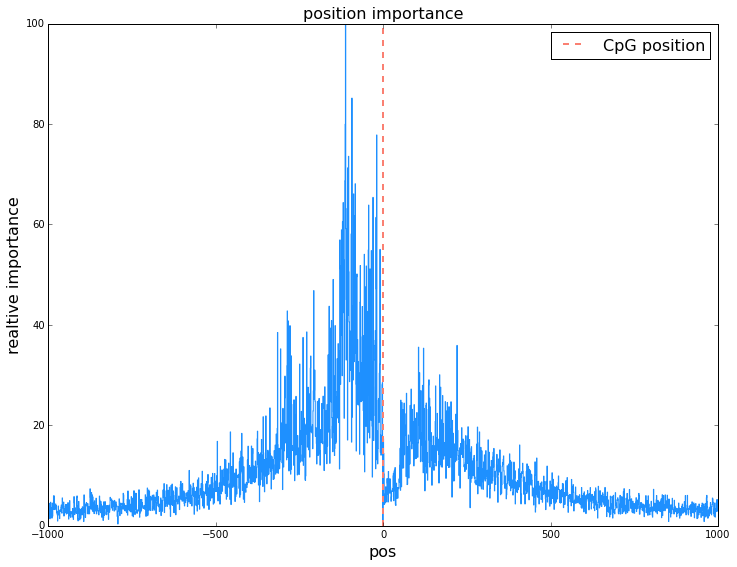

In [9]:
N=50000
rf = ensemble.RandomForestClassifier(n_estimators=100,min_samples_split=100)
model=rf.fit(x[0:N,:],y[0:N])
feature_importance = model.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

fig,ax=plt.subplots()
fig.set_size_inches(12,9)
ax.step(np.arange(len(feature_importance))-1000, feature_importance,lw=1,c='dodgerblue')
ax.axvline(0,lw=2,linestyle='dashed',c='salmon',label='CpG position')
ax.set_ylabel('realtive importance',fontsize=16)
ax.set_xlabel('pos',fontsize=16)
ax.set_xlim(-1000,1000)
ax.legend(fontsize=16)
dump=ax.set_title('position importance',fontsize=16)